## Imports

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn as sk
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
import warnings # to silence convergence warnings

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [2]:
# read in the data to pandas dataframes and convert to numpy arrays
GXtrain = pd.read_csv(os.path.join('..','Data', 'GolubGXtrain.csv'), header=None)
GXtest = pd.read_csv(os.path.join('..','Data', 'GolubGXtest.csv'), header=None)

Xtrain = np.array(GXtrain.loc[:, GXtrain.columns != 0])
Ytrain = np.array(GXtrain.loc[:, GXtrain.columns == 0]).ravel()

Xtest = np.array(GXtest.loc[:, GXtest.columns != 0])
Ytest = np.array(GXtest.loc[:, GXtest.columns == 0]).ravel()


### 2 We have a data material (Golub et al 1999) with gene expression levels from 72 patients with two forms of leukemia, acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL). Gene expression levels (how actively the cells are using the information in dierent genes) are measured for 7127 genes. We would like to build a biomarker for classification of the two cancer forms. Ideally, we would like to use onlya few variables.

> a) How can you use logistic regression here?

> b) Build a classifier for training data in GolubGXtrain.csv. What regularization method do you prefer if you want to have few genes in the biomarker?

CV lambda 1 std rule 0.63


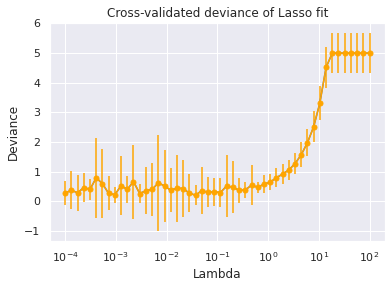

In [3]:
def devianceFunc(ytrue, yscores):
    return 2*sk.metrics.log_loss(ytrue, yscores, normalize=False)

lambdas = np.logspace(-4,2,50)
K = 10
CV = StratifiedKFold(K,shuffle=True)
X_standardizer = preprocessing.StandardScaler()

deviance = np.zeros((K, len(lambdas)))
with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")
    for i, (train_index, test_index) in enumerate(CV.split(Xtrain, Ytrain)):

        X_train = Xtrain[train_index, :]
        y_train = Ytrain[train_index]
        
        y_test = Ytrain[test_index]
        X_test = Xtrain[test_index]
        
        X_train = X_standardizer.fit_transform(X_train)
        X_test = X_standardizer.transform(X_test)

        for k, lambda_ in enumerate(lambdas):
            model = LogisticRegression(penalty = 'l1', C = 1/lambda_, solver='liblinear')
            model = model.fit(X_train, y_train)
            
            y_est = model.predict_proba(X_test)
            
            deviance[i,k] = devianceFunc(y_test, y_est)
            
testError = np.mean(deviance,axis=0)
testStd = np.std(deviance,axis=0)

# this is the index of the smallest error
minErrorIdx = np.argmin(testError)

# We want to find the simplest model that is only one standard error away from the smallest error
# We start by finding all indices that are less than one standard error away from the minimum error
J = np.where(testError < testError[minErrorIdx] + testStd[minErrorIdx])[0]

# then we take the simplest model (furthest to the right)
if (len(J) > 0):
    j = int(J[-1::])
else:
    j = minErrorIdx

Lambda_CV_1StdRule = lambdas[j]
print("CV lambda 1 std rule %0.2f" % Lambda_CV_1StdRule)


plt.figure()
plt.errorbar(lambdas, testError, testStd, marker='.', color='orange', markersize=10)
plt.semilogx(lambdas, testError)

plt.xlabel("Lambda")
plt.ylabel("Deviance")
plt.title("Cross-validated deviance of Lasso fit")
plt.show()

> c) How many variables do you end up with?

In [4]:
# After we know our optimal lambda we can create our model with our training set
X_train = X_standardizer.fit_transform(Xtrain)
X_test = X_standardizer.transform(Xtest)
modelOpt = LogisticRegression(penalty = 'l1', C = 1/Lambda_CV_1StdRule, solver='liblinear')
modelOpt = modelOpt.fit(X_train, Ytrain)

coef = modelOpt.coef_

nrCoefs = len(np.nonzero(coef)[1])

print("The number of non-zero coefficients in our optimal model is: %d" % nrCoefs)

The number of non-zero coefficients in our optimal model is: 17


> d) Use the obtained model to calculate accuracy on the test data.

In [5]:
y_estOpt = modelOpt.predict(X_test)

accuracy = np.sum(Ytest==modelOpt.predict(X_test))/len(Ytest)

print("The accuracy for our optimal model is: %0.2f" % accuracy)

The accuracy for our optimal model is: 0.89
